In [1]:
import os, glob, copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

# ── Config ─────────────────────────────────────────────────────────────────────
DATA_DIR    = "dataset5/csvs"
CLASS_NAMES = ["Neutral", "Bright", "Warm", "V-shape"]
NUM_BINS    = 128
FREQ_MIN    = 20
FREQ_MAX    = 20000
BATCH_SIZE  = 32
EPOCHS      = 300
LR          = 1e-3
WEIGHT_DECAY= 1e-4
PATIENCE    = 30        # early stopping patience on val loss
DEVICE      = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:

# Prepare log-spaced frequencies once
log_freqs = np.logspace(np.log10(FREQ_MIN), np.log10(FREQ_MAX), NUM_BINS)

# ── Data Loading + Preprocessing ───────────────────────────────────────────────
X, y = [], []

for idx, cls in enumerate(CLASS_NAMES):
    cls_dir = os.path.join(DATA_DIR, cls)
    for fp in glob.glob(os.path.join(cls_dir, "*.csv")):
        df = pd.read_csv(fp)
        freqs = df.iloc[:, 0].values
        spl   = df.iloc[:, 1].values
        # interpolate, replace NaNs with the mean
        vals = np.interp(log_freqs, freqs, spl)
        if np.isnan(vals).any():
            vals = np.nan_to_num(vals, nan=np.nanmean(vals))
        vals = vals - np.mean(vals)           # zero-mean normalize
        X.append(vals.astype(np.float32))
        y.append(idx)

X = np.stack(X)  # (N, 128)
y = np.array(y)  # (N,)

# Train/test split
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)
# PyTorch Dataset
val_frac = 0.2 / 0.80
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=val_frac, stratify=y_temp, random_state=42)

print(f"Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")
class IEMDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).unsqueeze(1)  # (N,1,128)
        self.y = torch.from_numpy(y).long()
    def __len__(self): return len(self.y)
    def __getitem__(self, i): return self.X[i], self.y[i]

train_loader = DataLoader(IEMDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(IEMDataset(X_val,   y_val),   batch_size=BATCH_SIZE)
test_loader  = DataLoader(IEMDataset(X_test,  y_test),  batch_size=BATCH_SIZE)

Train: 333 | Val: 111 | Test: 111


In [3]:
# ── Model Definition ────────────────────────────────────────────────────────────
class IEMCNN1D(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(1,  32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv1d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.15),
            nn.Conv1d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Flatten(),
            nn.Linear(64*(NUM_BINS//4), 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, n_classes)
        )

    def forward(self, x):
        return self.net(x)

model = IEMCNN1D(len(CLASS_NAMES)).to(DEVICE)

In [4]:



# ── Training Setup ─────────────────────────────────────────────────────────────
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2)

# Early stopping
best_val_loss = float('inf')
best_model_w = None
es_counter = 0

history = {'train_loss':[], 'val_loss':[]}

# ── Training Loop ──────────────────────────────────────────────────────────────
for epoch in range(1, EPOCHS+1):
    # Train
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
    train_loss = running_loss / len(train_loader.dataset)

    # Validate
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            logits = model(xb)
            loss = criterion(logits, yb)
            running_loss += loss.item() * xb.size(0)
    val_loss = running_loss / len(val_loader.dataset)

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    scheduler.step(val_loss)

    print(f"Epoch {epoch}/{EPOCHS} — train_loss: {train_loss:.4f}  val_loss: {val_loss:.4f}")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_w = copy.deepcopy(model.state_dict())
        es_counter = 0
    else:
        es_counter += 1
        if es_counter >= PATIENCE:
            print(f"Early stopping at epoch {epoch}")
            break

# Load best model
model.load_state_dict(best_model_w)


Epoch 1/300 — train_loss: 1.0572  val_loss: 0.9606
Epoch 2/300 — train_loss: 0.6528  val_loss: 0.6022
Epoch 3/300 — train_loss: 0.4179  val_loss: 0.3634
Epoch 4/300 — train_loss: 0.3381  val_loss: 0.2793
Epoch 5/300 — train_loss: 0.3126  val_loss: 0.2564
Epoch 6/300 — train_loss: 0.3733  val_loss: 0.2976
Epoch 7/300 — train_loss: 0.2897  val_loss: 0.2669
Epoch 8/300 — train_loss: 0.2357  val_loss: 0.2655
Epoch 9/300 — train_loss: 0.1859  val_loss: 0.2853
Epoch 10/300 — train_loss: 0.1705  val_loss: 0.3176
Epoch 11/300 — train_loss: 0.1871  val_loss: 0.2385
Epoch 12/300 — train_loss: 0.1820  val_loss: 0.3003
Epoch 13/300 — train_loss: 0.1951  val_loss: 0.2399
Epoch 14/300 — train_loss: 0.2129  val_loss: 0.2891
Epoch 15/300 — train_loss: 0.1981  val_loss: 0.2605
Epoch 16/300 — train_loss: 0.1371  val_loss: 0.2631
Epoch 17/300 — train_loss: 0.1461  val_loss: 0.3021
Epoch 18/300 — train_loss: 0.1310  val_loss: 0.2697
Epoch 19/300 — train_loss: 0.1444  val_loss: 0.2850
Epoch 20/300 — train_

<All keys matched successfully>


Test Accuracy: 0.910
Test F1 (macro): 0.874
Test Confusion Matrix:
 [[40  0  1  0]
 [ 1  5  0  0]
 [ 3  0 46  2]
 [ 0  1  2 10]]


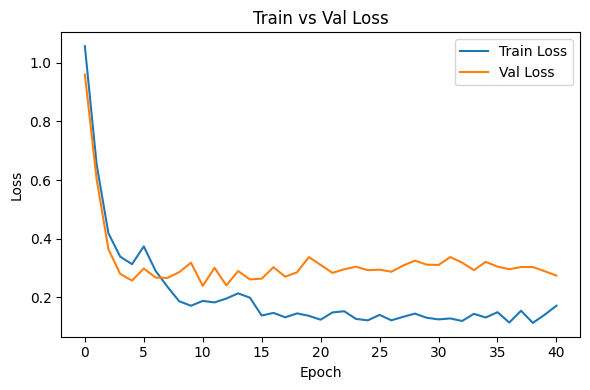


Test Accuracy: 0.910
Test F1 (macro): 0.874
Test Confusion Matrix:
 [[40  0  1  0]
 [ 1  5  0  0]
 [ 3  0 46  2]
 [ 0  1  2 10]]


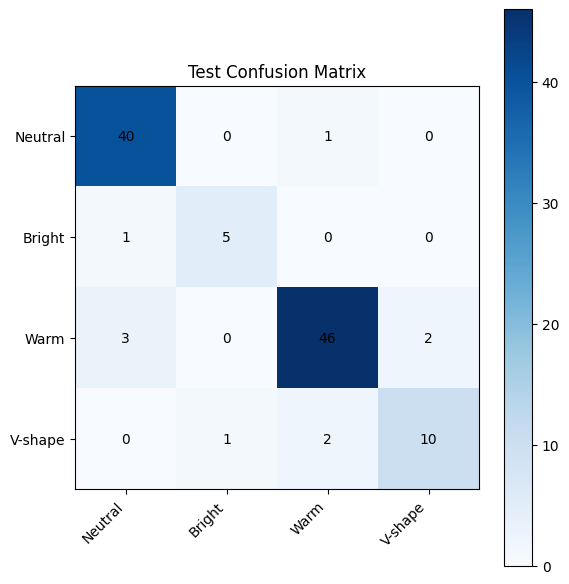

In [5]:
model.load_state_dict(best_model_w)
model.eval()
all_preds, all_true = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(DEVICE)
        preds = model(xb).argmax(axis=1).cpu().numpy()
        all_preds.extend(preds)
        all_true .extend(yb.numpy())

acc = accuracy_score(all_true, all_preds)
f1  = f1_score(all_true, all_preds, average='macro')
cm  = confusion_matrix(all_true, all_preds)

print(f"\nTest Accuracy: {acc:.3f}")
print(f"Test F1 (macro): {f1:.3f}")
print("Test Confusion Matrix:\n", cm)

# ── Plots ───────────────────────────────────────────────────────────────────────
# Loss curves
plt.figure(figsize=(6,4))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'],   label='Val Loss')
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(); plt.title("Train vs Val Loss")
plt.tight_layout()
plt.show()

cm = confusion_matrix(all_true, all_preds, labels=list(range(len(CLASS_NAMES))))

acc = accuracy_score(all_true, all_preds)
f1  = f1_score(all_true, all_preds, average='macro')

print(f"\nTest Accuracy: {acc:.3f}")
print(f"Test F1 (macro): {f1:.3f}")
print("Test Confusion Matrix:\n", cm)

# Plot confusion matrix heatmap for all classes
plt.figure(figsize=(6,6))
plt.imshow(cm, cmap='Blues')
plt.xticks(ticks=range(len(CLASS_NAMES)), labels=CLASS_NAMES, rotation=45, ha='right')
plt.yticks(ticks=range(len(CLASS_NAMES)), labels=CLASS_NAMES)
plt.title("Test Confusion Matrix")
for i in range(len(CLASS_NAMES)):
    for j in range(len(CLASS_NAMES)):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
plt.colorbar()
plt.tight_layout()
plt.show()